In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/processed_series_matrix.csv")
numeric_cols = df.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col != "Target"]

df_numeric = df[numeric_cols].copy()
y = df["Target"].values
X = df_numeric.values

In [ ]:
print("X shape:", X.shape)
print("First row of X:", X[0])
print("X type:", type(X))

X shape: (286, 45640)
First row of X: [ 1.6914121   1.69207043  1.69015636 ... 14.64641245  4.70043972
  3.        ]
X type: <class 'numpy.ndarray'>


In [ ]:
print(df.info())
print(df.dtypes.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Columns: 45647 entries, Unnamed: 0 to Target
dtypes: float64(45640), int64(1), object(6)
memory usage: 99.6+ MB
None
float64    45640
object         6
int64          1
Name: count, dtype: int64


Initial DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Columns: 45647 entries, Unnamed: 0 to Target
dtypes: float64(45640), int64(1), object(6)
memory usage: 99.6+ MB
None
float64    45640
object         6
int64          1
Name: count, dtype: int64

After dropping non-numeric columns:
X shape: (286, 45640)
Example row of X: [ 1.6914121   1.69207043  1.69015636 ... 14.64641245  4.70043972
  3.        ]
Final X shape: (286, 45640), y shape: (286,)

Class distribution:
  Class 0: 217
  Class 1: 69

Evaluating each model under different noise levels (10 runs each)...

=== Model: LR ===
Noise 0% => Summed Confusion Matrix (10 runs):
   [[TN=1018, FP=69],
    [FN=264, TP=79]]
   Accuracy=76.71%, TPR=23.03%, TNR=93.65%
Noise 5% => Summed Confusion Matrix (10 runs):
   [[TN=999, FP=88],
    [FN=261, TP=82]]
   Accuracy=75.59%, TPR=23.91%, TNR=91.90%
Noise 10% => Summed Confusion Matrix (10 runs):
   [[TN=978, FP=109],
    [FN=256, TP=87]]
   Accuracy=74

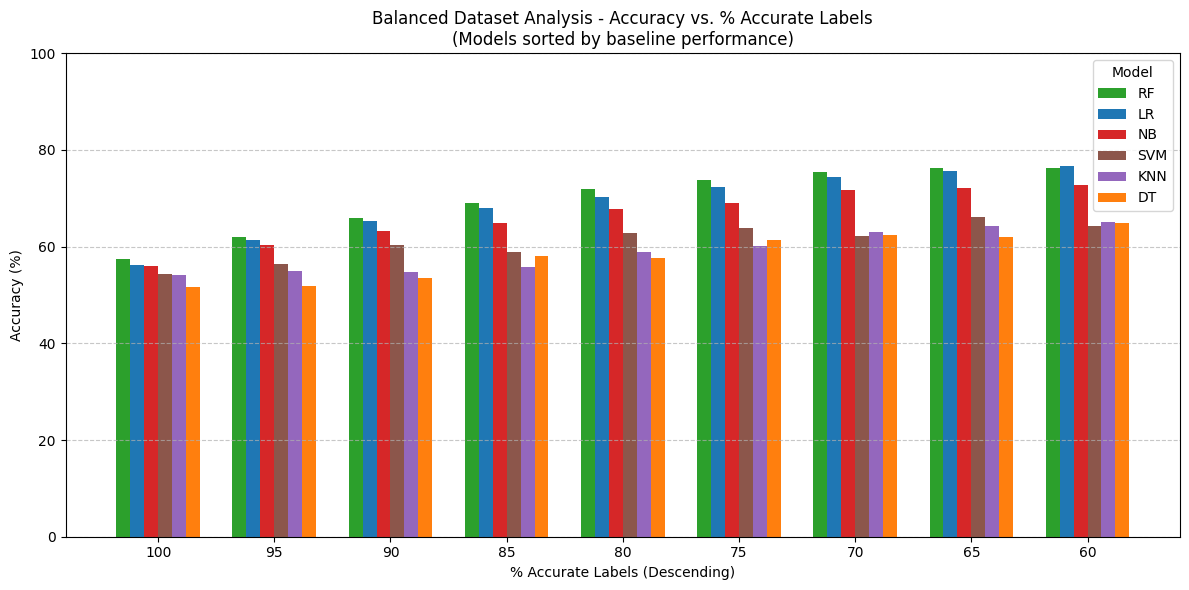

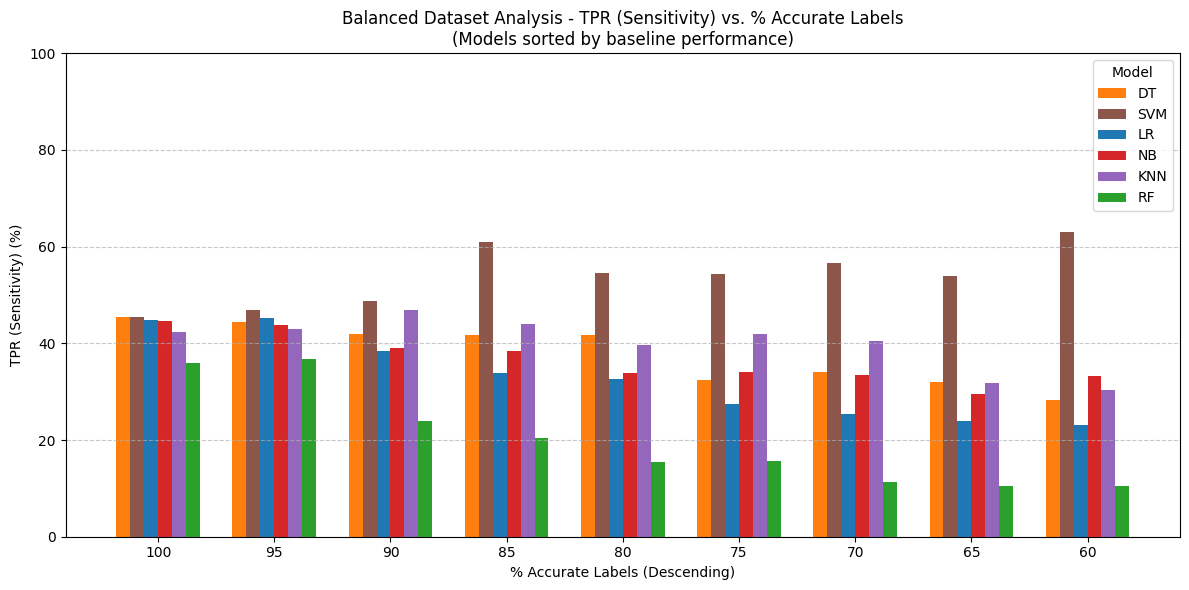

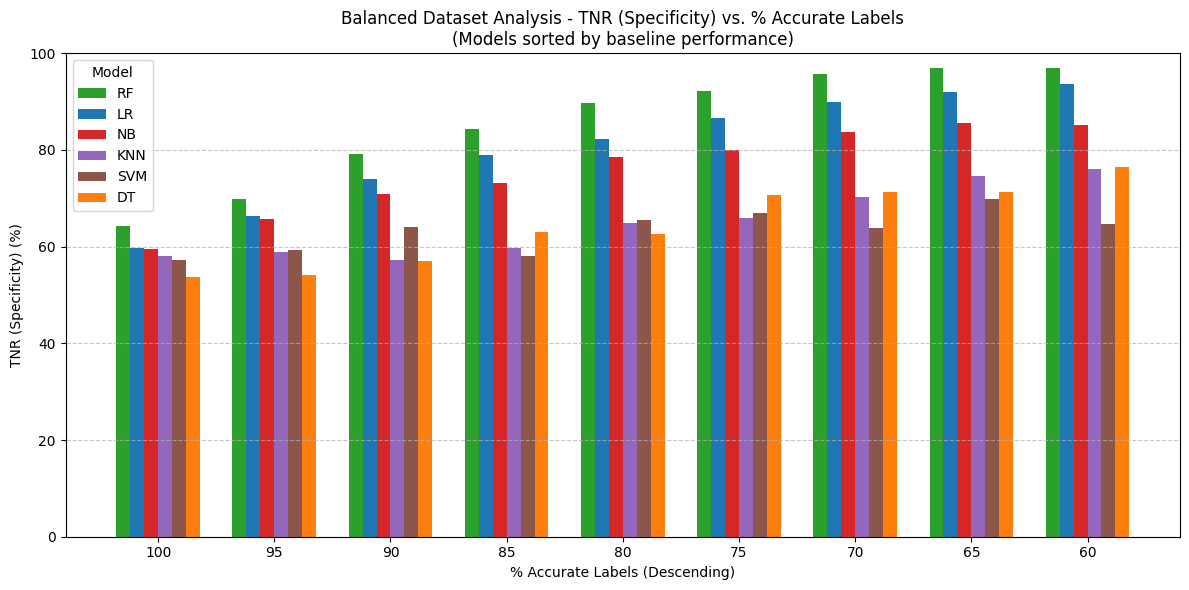


Analysis Complete!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')


RANDOM_STATE = 42

def load_data(csv_path):
    """
    Reads the CSV, drops non-numeric columns (except `Target`),
    and returns numeric feature matrix X and target vector y.
    """
    df = pd.read_csv(csv_path)
    print("Initial DataFrame info:")
    print(df.info())
    print(df.dtypes.value_counts())

    if "Target" not in df.columns:
        raise ValueError("The 'Target' column was not found in the CSV. Please check the column name.")

    y = df["Target"].values

    df.drop(columns=["Target"], inplace=True)


    drop_candidates = ["Unnamed: 0", "SampleID", "ID", "GSMID", "GSM"]
    for col in drop_candidates:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)


    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df = df[numeric_cols]

    X = df.values
    print(f"\nAfter dropping non-numeric columns:\nX shape: {X.shape}")
    print("Example row of X:", X[0])
    return X, y

def compute_metrics_from_confusion(tn, fp, fn, tp):
    """
    Given TN, FP, FN, TP, compute Accuracy, TPR (Sensitivity), TNR (Specificity).
    Returns metrics in percentages.
    """
    all_ = tn + fp + fn + tp
    if all_ == 0:
        return 0, 0, 0
    accuracy = (tp + tn) / all_
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    return accuracy * 100.0, tpr * 100.0, tnr * 100.0

def plot_metric_sorted(dataset_name, metric_name, metric_data, x_labels):
    """
    Plots a grouped bar chart for a given dataset and metric.
    - Models are sorted in descending order based on baseline (index 0) performance
      after we've reversed the arrays (baseline => 100% correct labels).
    - X-axis: % Accurate Labels in descending order [100, 95, ..., 60].
    - Y-axis: metric performance (0–100%).
    """

    sorted_models = sorted(metric_data.keys(), key=lambda m: metric_data[m][0], reverse=True)
    n_models = len(sorted_models)
    n_groups = len(x_labels)

    # For grouped bars
    x = np.arange(n_groups)
    bar_width = 0.12

    # Colors
    model_colors = {
        'LR': '#1f77b4',   # blue
        'DT': '#ff7f0e',   # orange
        'RF': '#2ca02c',   # green
        'NB': '#d62728',   # red
        'KNN': '#9467bd',  # purple
        'SVM': '#8c564b'   # brown
    }

    plt.figure(figsize=(12, 6))
    for i, model in enumerate(sorted_models):
        plt.bar(
            x + i * bar_width,
            metric_data[model],
            width=bar_width,
            color=model_colors.get(model, 'grey'),
            label=model
        )

    plt.xlabel('% Accurate Labels (Descending)')
    plt.ylabel(f'{metric_name} (%)')
    plt.title(
        f'{dataset_name} - {metric_name} vs. % Accurate Labels\n'
        '(Models sorted by baseline performance)'
    )
    # Position x-ticks in the center of the group
    plt.xticks(x + (n_models / 2 - 0.5) * bar_width, x_labels)
    plt.ylim(0, 100)
    plt.legend(title='Model')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":

    csv_path = "/content/drive/MyDrive/processed_series_matrix.csv"
    X, y = load_data(csv_path)

    # Check final X and y shape
    print(f"Final X shape: {X.shape}, y shape: {y.shape}")
    unique, counts = np.unique(y, return_counts=True)
    print("\nClass distribution:")
    for cls, cnt in zip(unique, counts):
        print(f"  Class {cls}: {cnt}")


    models = {
        'LR': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
        'DT': DecisionTreeClassifier(random_state=RANDOM_STATE),
        'RF': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
        'NB': GaussianNB(),
        'KNN': KNeighborsClassifier(),
        'SVM': SVC(probability=True, random_state=RANDOM_STATE, class_weight='balanced')
    }

    noise_levels = np.arange(0.0, 0.45, 0.05)

    acc_results = {m: [] for m in models.keys()}
    tpr_results = {m: [] for m in models.keys()}
    tnr_results = {m: [] for m in models.keys()}


    print("\nEvaluating each model under different noise levels (10 runs each)...")

    for model_key, model in models.items():
        print(f"\n=== Model: {model_key} ===")
        for noise_level in noise_levels:
            sum_tn, sum_fp, sum_fn, sum_tp = 0, 0, 0, 0

            for iteration in range(10):
                seed = RANDOM_STATE + iteration

                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.5, stratify=y, random_state=seed
                )

                # Introduce label noise in the training set
                y_train_noisy = y_train.copy()
                num_noisy = int(noise_level * len(y_train_noisy))
                np.random.seed(seed)
                noisy_indices = np.random.choice(len(y_train_noisy), size=num_noisy, replace=False)
                # Flip the chosen labels
                y_train_noisy[noisy_indices] = 1 - y_train_noisy[noisy_indices]

                ros = RandomOverSampler(random_state=seed)
                X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train_noisy)

                model.fit(X_train_bal, y_train_bal)

                y_pred = model.predict(X_test)

                tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()
                sum_tn += tn
                sum_fp += fp
                sum_fn += fn
                sum_tp += tp

            ACC, TPR, TNR = compute_metrics_from_confusion(sum_tn, sum_fp, sum_fn, sum_tp)

            acc_results[model_key].append(ACC)
            tpr_results[model_key].append(TPR)
            tnr_results[model_key].append(TNR)

            print(f"Noise {int(noise_level * 100)}% => Summed Confusion Matrix (10 runs):")
            print(f"   [[TN={sum_tn}, FP={sum_fp}],")
            print(f"    [FN={sum_fn}, TP={sum_tp}]]")
            print(f"   Accuracy={ACC:.2f}%, TPR={TPR:.2f}%, TNR={TNR:.2f}%")


    for m in models.keys():
        acc_results[m].reverse()
        tpr_results[m].reverse()
        tnr_results[m].reverse()

    # X-axis labels
    x_labels = np.array([100, 95, 90, 85, 80, 75, 70, 65, 60])
    dataset_name = "Balanced Dataset Analysis"

    # Accuracy plot
    plot_metric_sorted(dataset_name, 'Accuracy', acc_results, x_labels)

    # TPR plot
    plot_metric_sorted(dataset_name, 'TPR (Sensitivity)', tpr_results, x_labels)

    # TNR plot
    plot_metric_sorted(dataset_name, 'TNR (Specificity)', tnr_results, x_labels)

    print("\nAnalysis Complete!")